In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


2025-05-16 13:47:01.423028: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 13:47:01.434501: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747428421.446950   41141 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747428421.451236   41141 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747428421.461599   41141 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
image_size = (224, 224) 
batch_size = 32 
train_dir = 'src/../input/brain-tumor-classification-mri/Training' 
test_dir = 'src/../input/brain-tumor-classification-mri/Testing' 


# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomRotation(0.1), 
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomZoom(0.1)
# ])


train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred', # detect classes from input folder
    label_mode='categorical', # One-hot encoding
    image_size=image_size, # Resize images
    interpolation='bicubic', # Resize method
    batch_size=batch_size,
    shuffle=True # Shuffle the data
)

train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='bicubic',
    batch_size=batch_size,
    shuffle=False 
)

test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Optimize loading the dataset
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)



Found 2870 files belonging to 4 classes.


I0000 00:00:1747428424.244751   41141 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 394 files belonging to 4 classes.


In [3]:
X_list = []
y_list = []

for image_batch, label_batch in train_dataset:
    X_list.append(image_batch.numpy())
    y_list.append(label_batch.numpy())

for image_batch, label_batch in test_dataset:
    X_list.append(image_batch.numpy())
    y_list.append(label_batch.numpy()) 

#Conver batches into np arrays
X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

X, y = shuffle(X, y, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

2025-05-16 13:47:07.337092: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-16 13:47:07.723512: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


X_train shape: (2872, 224, 224, 3)
y_train shape: (2872, 4)
X_test shape: (392, 224, 224, 3)
y_test shape: (392, 4)


In [4]:
#Transfer learning with ResNet50
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [ ]:
#Build CNN model with Keras functional API 
model = base_model.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.3)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=base_model.input, outputs = model)

#Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# model.summary()

In [6]:
history = model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_split=0.1)

Epoch 1/20


I0000 00:00:1747428453.505493   41306 service.cc:152] XLA service 0x7fd774002bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747428453.506196   41306 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-05-16 13:47:33.844109: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747428456.057941   41306 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/81 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.2812 - loss: 2.4867  

I0000 00:00:1747428461.171296   41306 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.5173 - loss: 1.2692

2025-05-16 13:47:58.528084: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3318', 560 bytes spill stores, 560 bytes spill loads

2025-05-16 13:47:58.588743: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3318', 2916 bytes spill stores, 2904 bytes spill loads



81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 243ms/step - accuracy: 0.5185 - loss: 1.2656 - val_accuracy: 0.7812 - val_loss: 0.5748
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.7628 - loss: 0.6320 - val_accuracy: 0.7778 - val_loss: 0.5297
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.8011 - loss: 0.5199 - val_accuracy: 0.8438 - val_loss: 0.4508
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.8358 - loss: 0.4272 - val_accuracy: 0.8542 - val_loss: 0.4519
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.8399 - loss: 0.4024 - val_accuracy: 0.8472 - val_loss: 0.4019
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.8665 - loss: 0.3524 - val_accuracy: 0.8125 - val_loss: 0.4397
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.8617 - loss: 0.3592 - val_accuracy: 0.8681 - val_loss: 0.3669
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.8654 - loss: 0.3310 - val_accuracy: 0.8715 - val_loss:

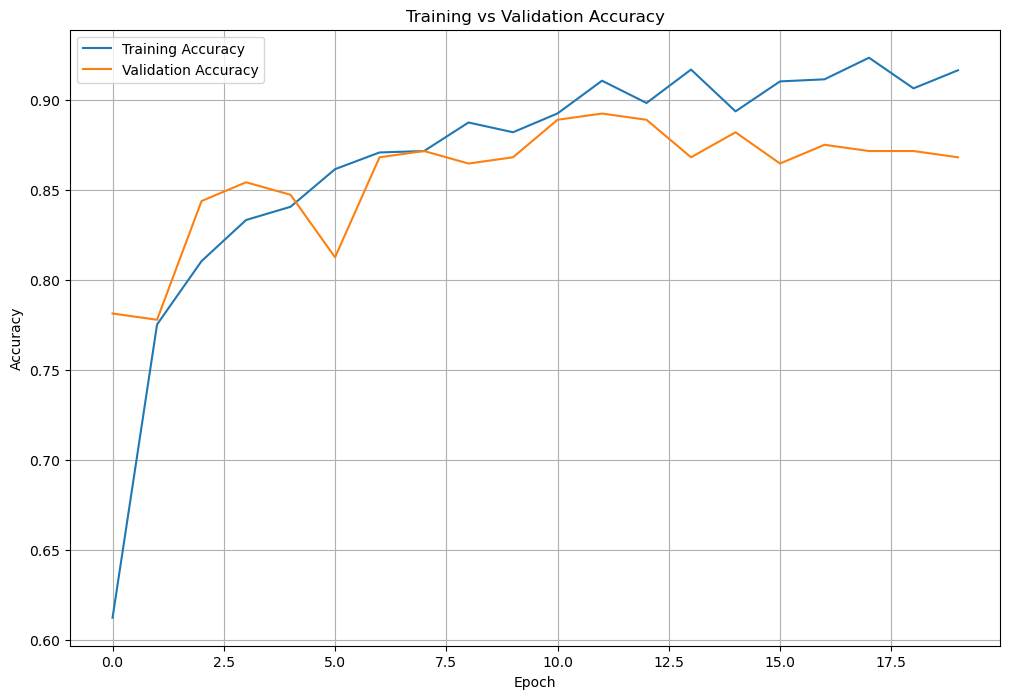

In [7]:
#Plot the accuracy on training and validation set (before fine-tuning)

plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
#Fine-tuning the pre-trained model
base_model.trainable = True

#Unfreeze only 40 last layers of the pre-trained model
for layer in base_model.layers[:-40]:
    layer.trainable = False

#Recompile the main model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#For callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint('effnet.keras', monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 4, min_delta = 0.001,
                              min_lr=1e-6, mode='auto',verbose=1)

#Train the model with callbacks
history = model.fit(X_train, y_train, epochs=12, batch_size=batch_size, validation_split=0.1, callbacks=[tensorboard,checkpoint,reduce_lr, early_stop])

Epoch 1/12
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8374 - loss: 0.4599
Epoch 1: val_accuracy improved from -inf to 0.85417, saving model to effnet.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 47s 316ms/step - accuracy: 0.8379 - loss: 0.4585 - val_accuracy: 0.8542 - val_loss: 0.4501 - learning_rate: 1.0000e-04
Epoch 2/12
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9683 - loss: 0.0763
Epoch 2: val_accuracy improved from 0.85417 to 0.90278, saving model to effnet.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step - accuracy: 0.9684 - loss: 0.0762 - val_accuracy: 0.9028 - val_loss: 0.3230 - learning_rate: 1.0000e-04
Epoch 3/12
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9931 - loss: 0.0281
Epoch 3: val_accuracy improved from 0.90278 to 0.92361, saving model to effnet.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.9931 - loss: 0.0282 - val_accuracy: 0.9236 - val_loss: 0.3148 - learning_rate: 1.0000e-04
Epoch 4/12
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step 

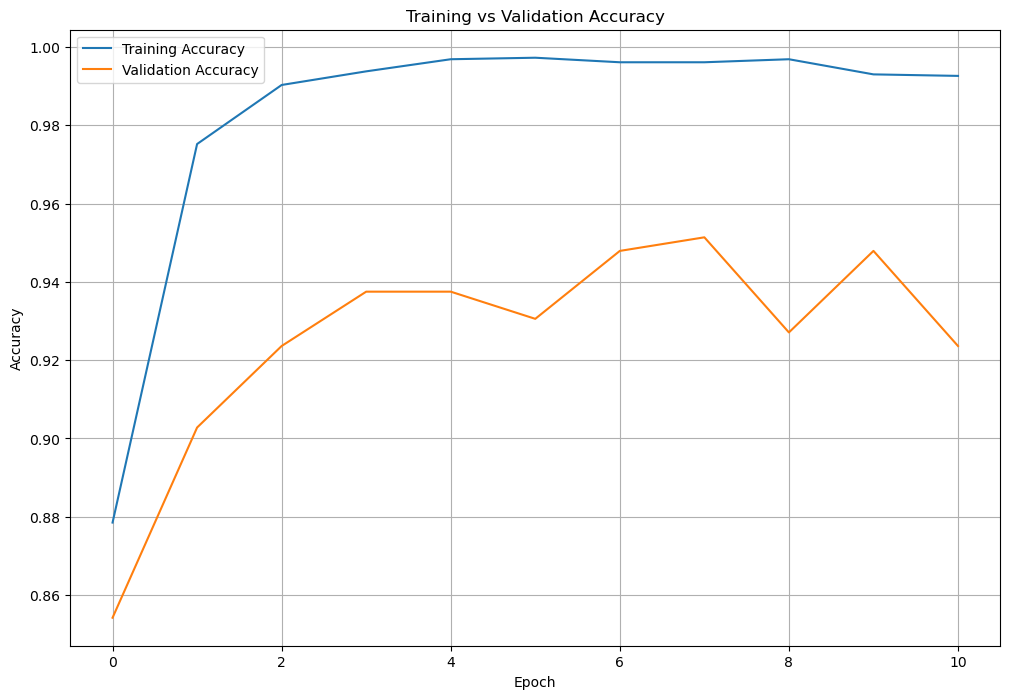

In [9]:
#Plot the accuracy on training and validation set (after fine-tuning)

plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
from sklearn.metrics import classification_report
#Perfrom prediction
y_pred = model.predict(X_test)

#Convert the highest probability to corresponding class label (index)
y_test_label = np.argmax(y_test, axis=1)
y_pred_label = np.argmax(y_pred, axis=1)

class_labels = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

#Compare to true labels
print(classification_report(y_test_label, y_pred_label, target_names=class_labels))

#Report accuracy and 
loss, accuracy = model.evaluate(X_test, y_test, verbose = 2)
print("Accuracy: ", accuracy)
print("Loss: ", loss)


12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

2025-05-16 13:53:49.678534: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3275', 8 bytes spill stores, 8 bytes spill loads

2025-05-16 13:53:49.902398: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3275', 440 bytes spill stores, 440 bytes spill loads



13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 583ms/step
              precision    recall  f1-score   support

      glioma       0.94      0.96      0.95       107
  meningioma       0.95      0.91      0.93       116
    no_tumor       0.97      1.00      0.98        63
   pituitary       0.97      0.97      0.97       106

    accuracy                           0.95       392
   macro avg       0.96      0.96      0.96       392
weighted avg       0.95      0.95      0.95       392

13/13 - 8s - 581ms/step - accuracy: 0.9541 - loss: 0.2232
Accuracy:  0.954081654548645
Loss:  0.22317983210086823


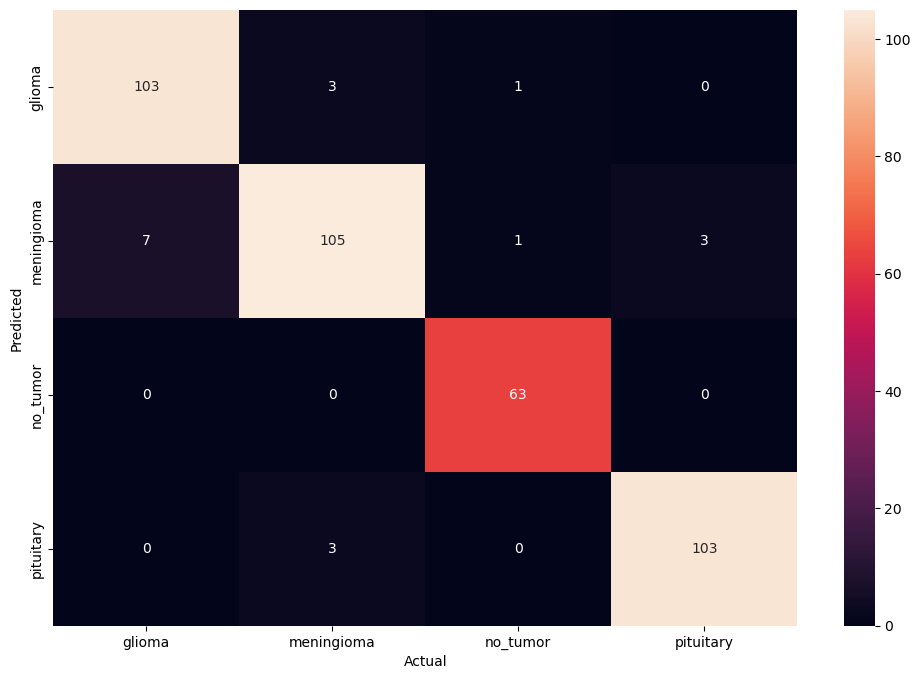

In [11]:
#Show confustion matrix

plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test_label, y_pred_label)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()